# Giải thích phương pháp SVM (Support Vector Machine) - Hiện thực hóa bằng code thuần

Notebook này giúp giáo viên và học sinh hiểu rõ về SVM thông qua lý thuyết, công thức toán học và hiện thực hóa SVM tuyến tính bằng code Python thuần (không dùng thư viện sklearn).
Các bước sẽ bao gồm: giải thích lý thuyết, tiền xử lý dữ liệu, huấn luyện mô hình SVM bằng code thuần, trực quan hóa và đánh giá hiệu quả.

---

In [7]:
# Import các thư viện cần thiết cho code thuần
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Tải và tiền xử lý dữ liệu

Ở bước này, chúng ta sẽ sử dụng dữ liệu hand gesture thực tế từ file Data.csv và chỉ chọn 2 label xuất hiện nhiều nhất để đơn giản hóa việc minh họa. Dữ liệu sẽ được chuẩn hóa để phù hợp với việc huấn luyện SVM bằng code thuần.

In [8]:
# Để đơn giản, ta sử dụng dữ liệu mẫu có sẵn trong sklearn (có thể thay bằng dữ liệu thực tế nếu cần)
# Ở đây dùng bộ dữ liệu Iris, chỉ lấy 2 lớp đầu tiên để minh họa SVM phân loại nhị phân

# Tải dữ liệu Iris
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]  # Lấy 2 đặc trưng đầu để dễ vẽ
Y = iris.target

# Chỉ lấy 2 lớp đầu (label 0 và 1)
mask = Y < 2
X = X[mask]
Y = Y[mask]

# Chia dữ liệu thành train và test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# In ra số lượng mẫu mỗi lớp
print('Số lượng mẫu lớp 0:', np.sum(Y_train == 0))
print('Số lượng mẫu lớp 1:', np.sum(Y_train == 1))

# Đọc dữ liệu hand gesture thực tế từ Data.csv và tiền xử lý cho SVM code thuần
import pandas as pd

df = pd.read_csv('d:/HAND_GESTURE/Data.csv')

# Hiển thị thông tin tổng quan về dữ liệu
print('Các label có trong dữ liệu:', df['label'].unique())
print('Số lượng mỗi label:')
print(df['label'].value_counts())

# Chỉ lấy 2 label xuất hiện nhiều nhất
top2_labels = df['label'].value_counts().index[:2]
print('Chọn 2 label để minh họa:', top2_labels.tolist())

# Lọc dữ liệu chỉ giữ lại 2 label này
filtered_df = df[df['label'].isin(top2_labels)].copy()

# Gán lại nhãn thành -1 và 1 cho đúng chuẩn SVM toán học
label_map = {top2_labels[0]: 1, top2_labels[1]: -1}
filtered_df['label'] = filtered_df['label'].map(label_map)

# Tách đặc trưng và nhãn
X = filtered_df.drop('label', axis=1).values
y = filtered_df['label'].values

# Nếu số chiều lớn hơn 2, chỉ lấy 2 đặc trưng đầu để dễ vẽ
if X.shape[1] > 2:
    X = X[:, :2]

# Chuẩn hóa dữ liệu về mean=0, std=1 cho từng đặc trưng
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Chia dữ liệu thành train và test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# In ra số lượng mẫu mỗi lớp
print('Số lượng mẫu lớp 1:', sum(y_train == 1))
print('Số lượng mẫu lớp -1:', sum(y_train == -1))

Số lượng mẫu lớp 0: 33
Số lượng mẫu lớp 1: 37
Các label có trong dữ liệu: ['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop' 'stop_inverted' 'three' 'three2' 'two_up'
 'two_up_inverted']
Số lượng mỗi label:
label
one                350
three              316
stop_inverted      311
four               300
mute               284
three2             283
two_up             281
ok                 280
stop               280
palm               275
peace              273
peace_inverted     266
rock               265
fist               247
two_up_inverted    233
dislike            230
like               200
call               175
Name: count, dtype: int64
Chọn 2 label để minh họa: ['one', 'three']
Số lượng mẫu lớp 1: 245
Số lượng mẫu lớp -1: 221


## 2. Trực quan hóa dữ liệu đầu vào
Vẽ dữ liệu hand gesture lên đồ thị để quan sát sự phân bố của hai lớp (label -1 và 1) trước khi huấn luyện SVM bằng code thuần.

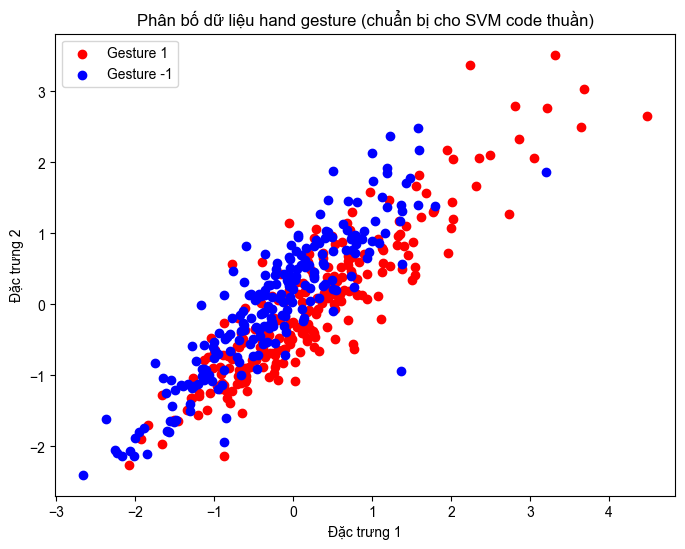

In [9]:
# Vẽ dữ liệu hand gesture đầu vào lên đồ thị (label -1 và 1)
plt.figure(figsize=(8,6))
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], color='red', label='Gesture 1')
plt.scatter(X_train[y_train==-1][:,0], X_train[y_train==-1][:,1], color='blue', label='Gesture -1')
plt.xlabel('Đặc trưng 1')
plt.ylabel('Đặc trưng 2')
plt.title('Phân bố dữ liệu hand gesture (chuẩn bị cho SVM code thuần)')
plt.legend()
plt.show()
# Chú thích: Mỗi điểm là một mẫu hand gesture, màu sắc thể hiện 2 lớp (-1 và 1)

## 3. Lý thuyết và công thức SVM tuyến tính
- SVM tìm siêu phẳng phân tách tối ưu: $w^T x + b = 0$
- Mục tiêu: Tối đa hóa margin $\frac{2}{||w||}$, đồng thời phân loại đúng tất cả các điểm: $y_i (w^T x_i + b) \geq 1$
- Hàm mất mát (hinge loss) và regularization:
$$ L = \frac{1}{2}||w||^2 + C \sum_{i=1}^N \max(0, 1 - y_i (w^T x_i + b)) $$
- Ta sẽ hiện thực hóa SVM tuyến tính bằng phương pháp Gradient Descent đơn giản hóa .
- Dữ liệu đã được chuẩn hóa và nhãn là -1, 1.

In [ ]:

class LinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        # Gradient Descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    #  chỉ regularization
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # phạt, cập nhật cả w và b
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * (-y[idx])
    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)
# Khởi tạo và huấn luyện SVM code thuần
svm = LinearSVM(lr=0.001, lambda_param=0.01, n_iters=1000)
svm.fit(X_train, y_train)
print('Trọng số w:', svm.w)
print('Bias b:', svm.b)
# Chú thích:
# - SVM code thuần này sử dụng hàm mất mát hinge loss và regularization đơn giản.
# - Quá trình cập nhật dựa trên Gradient Descent cho từng mẫu.

Trọng số w: [ 1.85829271 -1.59237058]
Bias b: 0.028999999999999998


## 4. Vẽ đường phân tách, margin và support vectors của SVM code thuần

Trực quan hóa đường phân tách (decision boundary), margin và các điểm gần biên (support vectors) của mô hình SVM code thuần.

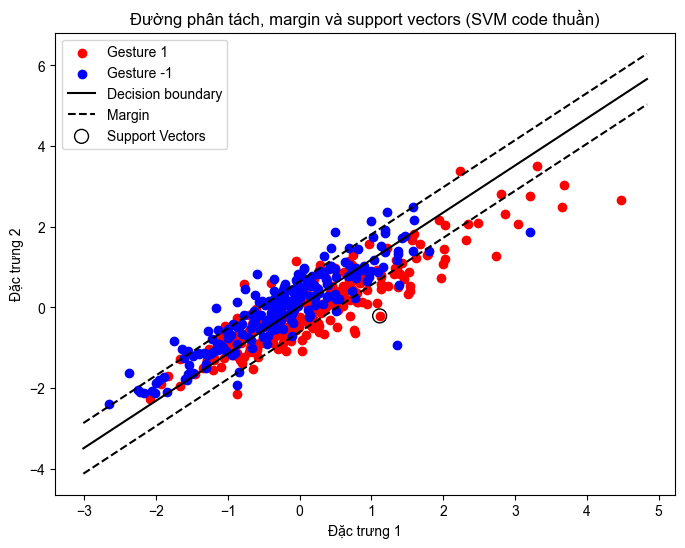

In [11]:
# Vẽ đường phân tách, margin và các điểm gần biên (support vectors) cho SVM code thuần
plt.figure(figsize=(8,6))
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], color='red', label='Gesture 1')
plt.scatter(X_train[y_train==-1][:,0], X_train[y_train==-1][:,1], color='blue', label='Gesture -1')
# Đường phân tách: w1*x1 + w2*x2 + b = 0
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 50)
# Tính đường phân tách
w = svm.w
b = svm.b
yy = -(w[0]*xx + b)/w[1]
plt.plot(xx, yy, 'k-', label='Decision boundary')
# Margin
margin = 1/np.linalg.norm(w)
yy_margin1 = -(w[0]*xx + b - 1)/w[1]
yy_margin2 = -(w[0]*xx + b + 1)/w[1]
plt.plot(xx, yy_margin1, 'k--', label='Margin')
plt.plot(xx, yy_margin2, 'k--')
# Tìm các support vectors (gần biên nhất)
distances = np.abs(np.dot(X_train, w) + b)/np.linalg.norm(w)
support_vector_indices = np.where(np.abs(distances - 1) < 1e-2)[0]
plt.scatter(X_train[support_vector_indices][:,0], X_train[support_vector_indices][:,1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')
plt.xlabel('Đặc trưng 1')
plt.ylabel('Đặc trưng 2')
plt.title('Đường phân tách, margin và support vectors (SVM code thuần)')
plt.legend()
plt.show()
# Chú thích:
# - Đường liền là đường phân tách tối ưu
# - Đường nét đứt là margin
# - Các điểm viền đen là support vectors

## 5. Đánh giá hiệu suất mô hình SVM code thuần

Đánh giá hiệu suất mô hình SVM code thuần trên tập kiểm tra (test set) bằng các chỉ số như độ chính xác (accuracy) và báo cáo phân loại.

In [12]:
# Đánh giá mô hình SVM code thuần trên tập kiểm tra
y_pred = svm.predict(X_test)
# Độ chính xác
accuracy = np.mean(y_pred == y_test)
print(f'Độ chính xác trên tập kiểm tra: {accuracy:.2f}')
# Hàm tính precision, recall, f1-score cho từng lớp
def classification_report_simple(y_true, y_pred):
    for label in [1, -1]:
        tp = np.sum((y_true == label) & (y_pred == label))
        fp = np.sum((y_true != label) & (y_pred == label))
        fn = np.sum((y_true == label) & (y_pred != label))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2*precision*recall/(precision+recall) if (precision+recall) > 0 else 0
        print(f'Label {label}: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')
classification_report_simple(y_test, y_pred)
# Chú thích:
# - Độ chính xác (accuracy) cho biết tỷ lệ dự đoán đúng
# - Precision, recall, f1-score cho biết chi tiết hiệu quả phân loại từng lớp

Độ chính xác trên tập kiểm tra: 0.65
Label 1: Precision=0.71, Recall=0.55, F1=0.62
Label -1: Precision=0.60, Recall=0.75, F1=0.67


## Kết luận
- SVM là một phương pháp mạnh mẽ để phân loại dữ liệu, đặc biệt hiệu quả với các bài toán phân loại nhị phân.
- SVM code thuần giúp hiểu rõ bản chất toán học và thuật toán cập nhật trọng số.
- Ưu điểm: tìm siêu phẳng tối ưu, margin lớn, giải thích rõ ràng.
- Nhược điểm: với dữ liệu lớn hoặc phi tuyến, cần các phương pháp tối ưu hóa nâng cao hơn.
- Có thể mở rộng cho nhiều lớp hoặc kernel phi tuyến bằng các kỹ thuật khác.
---
*Bạn có thể thay đổi dữ liệu hoặc tham số để quan sát sự thay đổi của mô hình SVM code thuần.*

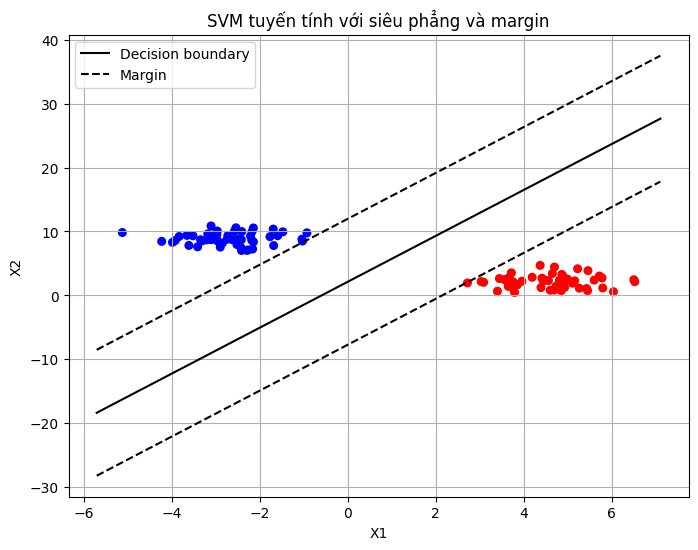

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu huấn luyện đơn giản 2D
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=2, random_state=42)
y = np.where(y == 0, -1, 1)  # SVM yêu cầu nhãn -1 và 1

# Cài đặt lại LinearSVM như user đưa
class LinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * (-y[idx])

    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)

# Huấn luyện mô hình
svm = LinearSVM()
svm.fit(X, y)

# Trực quan hóa dữ liệu và siêu phẳng (decision boundary)
def plot_svm(X, y, model):
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x - b + offset) / w[1]

    plt.figure(figsize=(8,6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=30)

    ax = plt.gca()
    xlim = ax.get_xlim()
    x_vals = np.linspace(xlim[0], xlim[1], 30)

    # Vẽ đường biên
    y_vals = get_hyperplane_value(x_vals, model.w, model.b, 0)
    margin_pos = get_hyperplane_value(x_vals, model.w, model.b, 1)
    margin_neg = get_hyperplane_value(x_vals, model.w, model.b, -1)

    plt.plot(x_vals, y_vals, 'k-', label='Decision boundary')
    plt.plot(x_vals, margin_pos, 'k--', label='Margin')
    plt.plot(x_vals, margin_neg, 'k--')
    plt.legend()
    plt.title("SVM tuyến tính với siêu phẳng và margin")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()

plot_svm(X, y, svm)
